In [1]:
import gym
from gym import Wrapper
import numpy as np
import matplotlib.pyplot as plt
from env.custom_hopper import *
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv


/home/federica/anaconda3/envs/mldl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomEnvWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.env = env

    def set_env_parameter(self, index, value):
        # Modify the environment based on the index and value
        if index == 0:  # Thigh mass
            self.env.model.body_mass[self.env.model.body_name2id('thigh')] = value
        elif index == 1:  # Leg mass
            self.env.model.body_mass[self.env.model.body_name2id('leg')] = value
        elif index == 2:  # Foot mass
            self.env.model.body_mass[self.env.model.body_name2id('foot')] = value
        elif index == 3:  # Thigh joint friction
            self.env.model.dof_frictionloss[self.env.model.joint_name2id('thigh_joint')] = value
        elif index == 4:  # Leg joint friction
            self.env.model.dof_frictionloss[self.env.model.joint_name2id('leg_joint')] = value
        elif index == 5:  # Foot joint friction
            self.env.model.dof_frictionloss[self.env.model.joint_name2id('foot_joint')] = value
        else:
            raise NotImplementedError("Invalid parameter index")
        
    def set_env_parameters(self, parameters):
        for index, value in enumerate(parameters):
            self.set_env_parameter(index, value)

In [3]:
def evaluate_performance(env, model):
    obs = env.reset()
    total_reward = 0
    total_speed = 0
    total_stability = 0
    total_balance = 0
    done = False
    steps = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        
        # Extract the dictionary from the list
        info_dict = info[0] if isinstance(info, list) and len(info) > 0 else {}
        
        # Safely extract metrics from the dictionary
        total_reward += reward
        total_speed += info_dict.get('speed', 0)
        total_stability += info_dict.get('stability', 0)
        total_balance += info_dict.get('balance', 0)
        steps += 1
    
    avg_speed = total_speed / steps if steps > 0 else 0
    avg_stability = total_stability / steps if steps > 0 else 0
    avg_balance = total_balance / steps if steps > 0 else 0
    return total_reward, avg_speed, avg_stability, avg_balance

In [4]:
# Set up the environment
original_env = gym.make('CustomHopper-v0')
wrapped_env = CustomEnvWrapper(original_env)
env = DummyVecEnv([lambda: wrapped_env])
model = PPO('MlpPolicy', env, verbose=0)

# ADR Parameters: Define custom ranges for thigh, leg, and foot masses, and joint frictions
phi_i_L = np.array([3.5, 2.3, 4.6, 0.001, 0.001, 0.001])  # Initial lower bounds
phi_i_H = np.array([4.5, 3.3, 5.5, 0.5, 0.5, 0.5])  # Initial upper bounds
phi = np.random.uniform(phi_i_L, phi_i_H)
delta = 0.1
t_L, t_H = 0.3, 0.7
m = 10

D_L = [[] for _ in range(len(phi))]
D_H = [[] for _ in range(len(phi))]
performance_history = []
speed_history = []
stability_history = []
balance_history = []
under_1000_rewards = []


In [5]:
for episode in range(10000):
    lambda_i = np.random.choice(len(phi))  # Randomize one parameter at a time
    x = np.random.rand()
    if x < 0.5:
        env_param = phi_i_L[lambda_i]
        D_i = D_L
    else:
        env_param = phi_i_H[lambda_i]
        D_i = D_H
    
    wrapped_env.set_env_parameter(lambda_i, env_param)
    
    model.learn(total_timesteps=1000)
    reward, avg_speed, avg_stability, avg_balance = evaluate_performance(env, model)
    
    # Update history
    D_i[lambda_i].append(reward)
    performance_history.append(reward)
    speed_history.append(avg_speed)
    stability_history.append(avg_stability)
    balance_history.append(avg_balance)
    
    # Save episodes with reward < 1000
    if reward < 1000:
        params = wrapped_env.env.model.body_mass.tolist() + wrapped_env.env.model.dof_frictionloss.tolist()
        under_1000_rewards.append((episode, params))
    
    # Determine which parameter to adjust based on performance
    if len(D_i[lambda_i]) >= m:
        avg_p = np.mean(D_i[lambda_i])
        D_i[lambda_i] = []
        if avg_p >= t_H:
            phi[lambda_i] += delta
            phi_i_H[lambda_i] += delta
        elif avg_p <= t_L:
            phi[lambda_i] -= delta
            phi_i_L[lambda_i] -= delta
        
        # Ensure phi stays within the current bounds
        phi[lambda_i] = np.clip(phi[lambda_i], phi_i_L[lambda_i], phi_i_H[lambda_i])
    
    wrapped_env.set_env_parameters(phi)

    if episode % 10 == 0:
        print(f"Episode {episode}: Reward = {reward}, Parameters = {wrapped_env.env.model.body_mass.tolist() + wrapped_env.env.model.dof_frictionloss.tolist()}")


Episode 0: Reward = [82.41076], Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.1506000695240701, 0.01031005094678045]
Episode 10: Reward = [235.24445], Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.1506000695240701, 0.01031005094678045]
Episode 20: Reward = [367.1272], Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.1506000695240701, 0.01031005094678045]
Episode 30: Reward = [562.5425], Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.1506000695240701, 0.01031005094678045]
Episode 40: Reward = [593.0496], Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.1506


Episodes with rewards under 1000:
Episode 0: Parameters = [0.0, 3.534291735288517, 3.9269908169872427, 2.7143360527015816, 5.0893800988154645, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0]
Episode 1: Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.5, 0.1506000695240701, 0.01031005094678045]
Episode 2: Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.5, 0.01031005094678045]
Episode 3: Parameters = [0.0, 3.534291735288517, 4.5, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.1506000695240701, 0.01031005094678045]
Episode 4: Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.49022882942231877, 0.1506000695240701, 0.001]
Episode 5: Parameters = [0.0, 3.534291735288517, 4.475847316120149, 2.6783270808929345, 5.0435777164962845, 0.0, 0.0, 0.0, 0.001, 0.15060006952

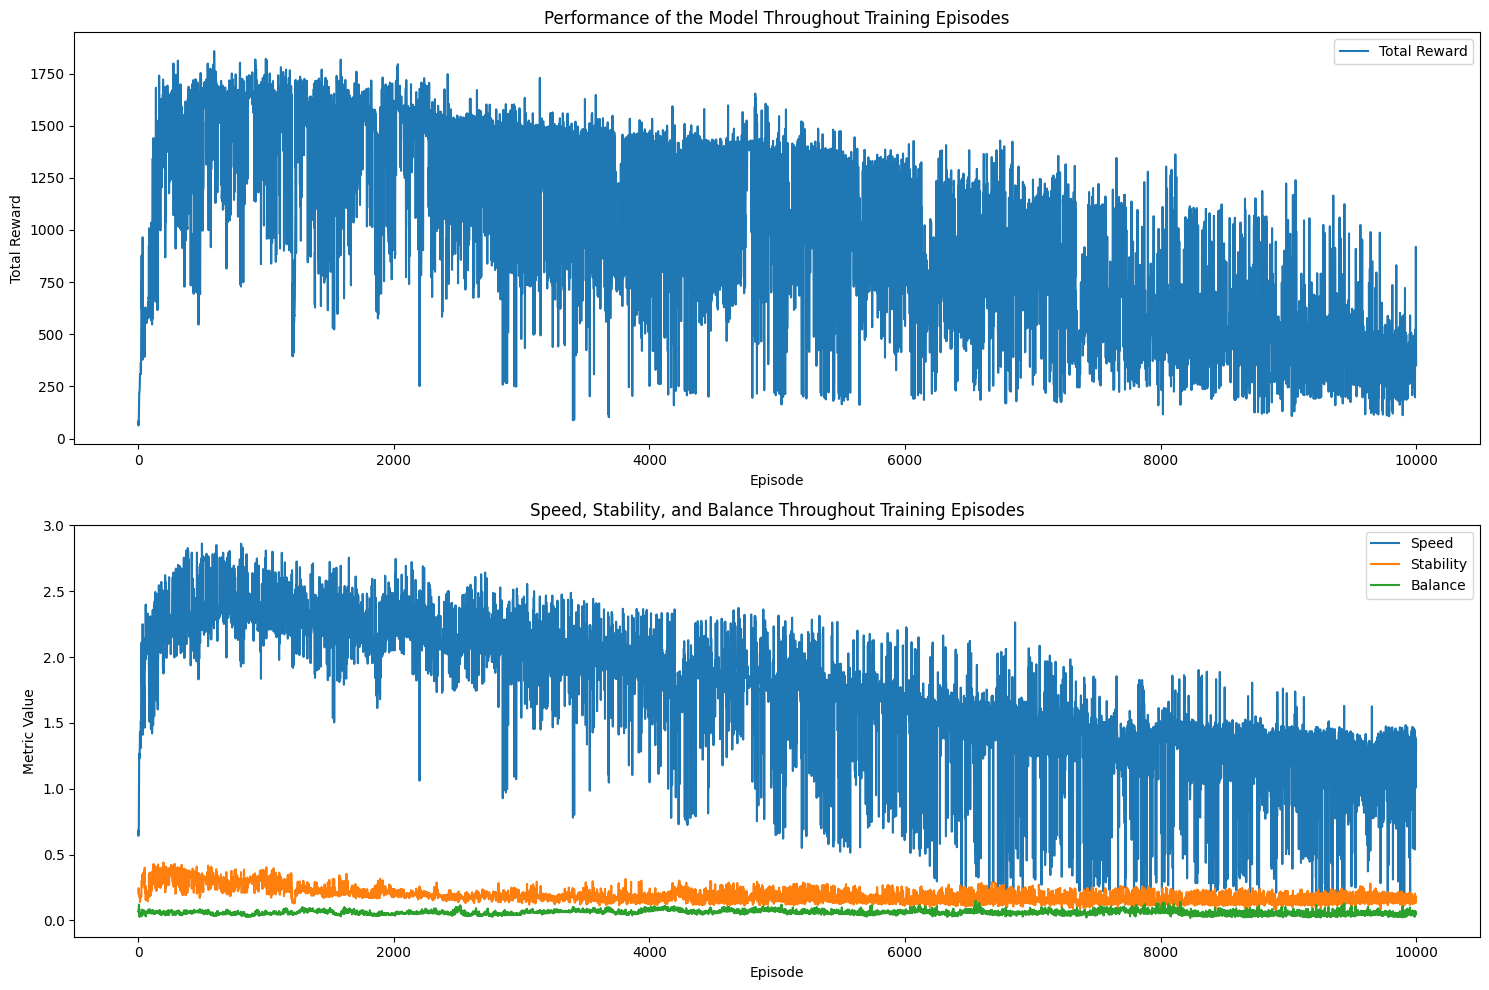

In [6]:
# After training, print episodes with rewards < 1000
print("\nEpisodes with rewards under 1000:")
for ep, params in under_1000_rewards:
    print(f"Episode {ep}: Parameters = {params}")

# Plotting and saving plots as PNG files
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(performance_history, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Performance of the Model Throughout Training Episodes')
plt.legend()
plt.savefig('performance_plot.png')  # Save the plot as a PNG

plt.subplot(2, 1, 2)
plt.plot(speed_history, label='Speed')
plt.plot(stability_history, label='Stability')
plt.plot(balance_history, label='Balance')
plt.xlabel('Episode')
plt.ylabel('Metric Value')
plt.title('Speed, Stability, and Balance Throughout Training Episodes')
plt.legend()
plt.tight_layout()
plt.savefig('metrics_plot.png')  # Save the second plot as a PNG

plt.show()
